In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import glob
from math import sqrt
from pprint import pprint
from time import gmtime, strftime
SPINE_COLOR = 'gray'
sns.set(style="whitegrid") # or "darkgrid"

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8,       #'text.fontsize': 8, # was 10
              'legend.fontsize': 6.5, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'lines.linewidth' : 0.4,
              'lines.markersize' : 0.4,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

linewidth=497
DPI=96
#latexify(fig_width=linewidth/DPI, fig_height=int(linewidth/2.3/DPI))
latexify(fig_width=linewidth/DPI/1.7, fig_height=int(linewidth/2.3/DPI))

In [ ]:
#CCDFs
# one-way delay (application layer)
experimentsC=[]
mqs='mqs-4'
for f in glob.iglob('./crosstraffic_'+mqs+'/*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfapp['length']
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    sortedOneWayDelay = dfapp['onewaydelay'].sort_values()
    #print(sortedOneWayDelay.size)
    
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfapp.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)
            
    if(outdated.size == 0):
        outdatedsize=0; 
        outdatedmin=0;
        outdatedmean=0;
        outdatedmax=0;
    else:
        outdatedsize= outdated.size;
        outdatedmin=outdated.min();
        outdatedmean=outdated.mean();
        outdatedmax=outdated.max();
        
#     print('Outdated:', outdatedsize, 'min:', outdatedmin, 'mean:', outdatedmean, 
#             'median:', outdated.median(), 'max:', outdatedmax, ' (all delays in ms)')
#     print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
#             'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)\n')
    
    
#     #build the CDF
#     cum_dist = np.linspace(1.,0.,len(sortedOneWayDelay))
#     cdf = pd.Series(cum_dist, index=sortedOneWayDelay)
#     fig = plt.figure() #this line makes a plot for every file
#     fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
#     #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

#     fig.set_xlabel('Delay of packets (ms)')
#     fig.set_yscale('log')
#     plt.tight_layout()
#     plt.savefig(f+"ccdf_one-way-delay_app.pdf")
    
    experimentName=f[f.find('2019'):]
    #print(experimentName)
    experimentsC.append([experimentName, sortedOneWayDelay.size, inTime.size, inTime.min(), inTime.mean(), inTime.max(), outdatedsize, outdatedmin, outdatedmean, outdatedmax])

#pprint(experimentsC)

# cut out ephemeral version name from experiment name
for i in experimentsC:
    if 'non' in i[0][i[0].rfind('crosstraffic')+13:i[0].rfind('ephemeral')+9]:
         i[0] = 'N'
    if 'light' in i[0][i[0].rfind('crosstraffic')+13:i[0].rfind('ephemeral')+9]:
         i[0] = 'L'
    if 'full' in i[0][i[0].rfind('crosstraffic')+13:i[0].rfind('ephemeral')+9]:
         i[0] = 'F'
    #i[0] = i[0][i[0].rfind('crosstraffic')+13:i[0].rfind('ephemeral')+9]

dfAll = pd.DataFrame()
dfAll['Version'] = pd.Series(i[0] for i in experimentsC)
dfAll['received'] = pd.Series(i[1] for i in experimentsC)
dfAll['inTime'] = pd.Series(i[2] for i in experimentsC)
dfAll['inTime_min'] = pd.Series(i[3] for i in experimentsC)
dfAll['inTime_mean'] = pd.Series(i[4] for i in experimentsC)
dfAll['inTime_max'] = pd.Series(i[5] for i in experimentsC)
dfAll['outdated'] = pd.Series(i[6] for i in experimentsC)
dfAll['outdated_min'] = pd.Series(i[7] for i in experimentsC)
dfAll['outdated_mean'] = pd.Series(i[8] for i in experimentsC)
dfAll['outdated_max'] = pd.Series(i[9] for i in experimentsC)
dfAll.sort_values(by=['Version'], ascending=False, inplace=True)

#print(dfAll)

fig, (ax1, ax2) = plt.subplots(1, 2) #two plots in one figure
#fig.suptitle('Maximum Queue Size: '+ mqs[-1:]) #title = maximum queue size

#messages received in time
sns.boxplot(x='Version', y='inTime', data=dfAll, fliersize=0.0, ax=ax1)
ax1.set_ylabel('In-Time Messages')

#outdated messages received
sns.boxplot(x='Version', y='outdated', data=dfAll, fliersize=0.0, ax=ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.set_ylabel('Outdated Messages')

plt.tight_layout()
plt.savefig(f+mqs+"_crosstraffic_inTime+outdated.pdf")


In [ ]:
# HOLES: APP LEVEL
# msgs consecutively lost (holes)
experiments = []
model='ct-ge' #ge or random
for f in glob.iglob('./'+model+'/*202001*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfstream['length']
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: int(x) / 1000) # from us to ms
    
    holes = []
    h=1;
    case=''
    for i, seconds in enumerate(dfapp.seconds_offset):
        if (i+1 < dfapp.seconds_offset.size): #out of bounds check
            t1 = seconds;
            t2 = dfapp.seconds_offset[i+1]
            n1 = dfapp.msg_number[i]
            n2 = dfapp.msg_number[i+1]
            if(t2 - t1 > 0.2): # hole detected by offset (but maybe msg before was also outdated!)
                
                if(dfapp.onewaydelay[i] < 100): # was msg[i] already outdated?
                    # msg[i] not outdated
                    
                    if(dfapp.onewaydelay[i+1] > 100): #is msg[i+1] actually the end of the hole?
                        k=2 #look forward until next "msg-in-time" was found
                        while (dfapp.index[i+k] != None and dfapp.onewaydelay[i+k] > 100):
                            k+=1
                        if(dfapp.index[i+k]) != None:
                            n2 = dfapp.msg_number[i+k]
                            t2 = dfapp.seconds_offset[i+k]
                            case = 'i to i+k'
                    else:
                        case = 'i to i+1'
                        
                else:
                    # msg[i] is outdated
                    
                    j=1 # look back until last "msg-in-time" was found
                    while (dfapp.onewaydelay[i-j] > 100):
                        j+=1
                    n1 = dfapp.msg_number[i-j] #update real beginning of hole
                    t1 = dfapp.seconds_offset[i-j]
                    
                    if(dfapp.onewaydelay[i+1] > 100): #is it actually the end of the hole?
                        k=2 #look forward until next "msg-in-time" was found
                        while (dfapp.index[i+k] != None and dfapp.onewaydelay[i+k] > 100):
                            k+=1
                        if(dfapp.index[i+k]) != None:
                            n2 = dfapp.msg_number[i+k]
                            t2 = dfapp.seconds_offset[i+k]
                            case = 'i-j to i+k'
                        else:
                            print('OUT OF BOUNDS')
                    else: # it is already the end
                        case = 'i-j to i+1'
                        
                holes.append([n1, n2, n2-n1, (t2-t1) * 1000, case]) # msg 1, msg 2, msg difference, time difference
                #print(h, case, [n1, n2, n2-n1, str(round((t2-t1) * 1000, 2))])
                #h+=1
    
    holeTimes = pd.Series(i[3] for i in holes)
    holeMsgs = pd.Series(i[2] for i in holes)
    
#     print('Hole sizes (ms): occurrences=', holeTimes.size, 'min=', holeTimes.min(), 'mean=', round(holeTimes.mean(), 2), 'median=', round(holeTimes.median(), 2), 
#           'max=', holeTimes.max())
#     print('Hole sizes (msgs): occurrences=', holeMsgs.size, 'min=', holeMsgs.min(), 'mean=', round(holeMsgs.mean(), 2), 'median=', round(holeMsgs.median(), 2), 
#           'max=', holeMsgs.max(), '\n')
    
   
    #set parameters and check if occurences = 0 -> mean, median, max also 0 then
    
    experimentName=f[f.find('2020'):]
    #print(experimentName)
    experiments.append([experimentName, holeTimes.size, round(holeTimes.mean(), 2), round(holeTimes.median(), 2), holeTimes.max()])
    #experiments.append([experimentName, holeTimes.mean()])

# build dataframes from values computed above
#pprint(experiments)

dfNE = pd.DataFrame()
dfNE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments if ('non-ephemeral' in i[0]))
dfNE['occurrences'] = pd.Series(i[1] for i in experiments if ('non-ephemeral' in i[0]))
dfNE['mean'] = pd.Series(i[2] for i in experiments if ('non-ephemeral' in i[0]))
dfNE['median'] = pd.Series(i[3] for i in experiments if ('non-ephemeral' in i[0]))
dfNE['max'] = pd.Series(i[4] for i in experiments if ('non-ephemeral' in i[0]))

dfLE = pd.DataFrame()
dfLE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments if ('light-ephemeral' in i[0]))
dfLE['occurrences'] = pd.Series(i[1] for i in experiments if ('light-ephemeral' in i[0]))
dfLE['mean'] = pd.Series(i[2] for i in experiments if ('light-ephemeral' in i[0]))
dfLE['median'] = pd.Series(i[3] for i in experiments if ('light-ephemeral' in i[0]))
dfLE['max'] = pd.Series(i[4] for i in experiments if ('light-ephemeral' in i[0]))

dfFE = pd.DataFrame()
dfFE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments if ('full-ephemeral' in i[0]))
dfFE['occurrences'] = pd.Series(i[1] for i in experiments if ('full-ephemeral' in i[0]))
dfFE['mean'] = pd.Series(i[2] for i in experiments if ('full-ephemeral' in i[0]))
dfFE['median'] = pd.Series(i[3] for i in experiments if ('full-ephemeral' in i[0]))
dfFE['max'] = pd.Series(i[4] for i in experiments if ('full-ephemeral' in i[0]))


#print(dfNE, '\n', dfLE, '\n', dfFE) 


# MEAN (in ms)
fig = dfNE.plot(x="lossrate", y="mean", kind='scatter', color="DarkBlue", s=5)
x = dfNE.lossrate
y = dfNE['mean']
fig.plot(x, y, 'b', marker="o", ms=2)
x = dfLE.lossrate
y1 = dfLE['mean']
fig.plot(x, y1, 'y', marker="v", ms=2)
x = dfFE.lossrate
y2 = dfFE['mean']
fig.plot(x, y2, 'r', marker="D", ms=2)

fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

plt.xticks(dfNE.lossrate.tolist())
fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Mean size of\ndata holes (ms)')
plt.tight_layout()
#plt.savefig(f+model+"_dataholes_mean.pdf")

# MAX (in ms)
fig = dfNE.plot(x="lossrate", y="max", kind='scatter', color="DarkBlue", s=5)
x = dfNE.lossrate
y = dfNE['max']
fig.plot(x, y, 'b', marker="o", ms=2)
x = dfLE.lossrate
y1 = dfLE['max']
fig.plot(x, y1, 'y', marker="v", ms=2)
x = dfFE.lossrate
y2 = dfFE['max']
fig.plot(x, y2, 'r', marker="D", ms=2)

fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

plt.xticks(dfNE.lossrate.tolist())
fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Maximum size of\ndata holes (ms)')
plt.tight_layout()
#plt.savefig(f+model+"_dataholes_max.pdf")


# OCCURRENCES (in number of holes)
fig = dfNE.plot(x="lossrate", y="occurrences", kind='scatter', color="DarkBlue", s=5)
x = dfNE.lossrate
y = dfNE['occurrences']
fig.plot(x, y, 'b', marker="o", ms=2)
x = dfLE.lossrate
y1 = dfLE['occurrences']
fig.plot(x, y1, 'y', marker="v", ms=2)
x = dfFE.lossrate
y2 = dfFE['occurrences']
fig.plot(x, y2, 'r', marker="D", ms=2)

fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best") #bbox_to_anchor=(1,1)

plt.xticks(dfNE.lossrate.tolist())
fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Occurence of\ndata holes')

plt.tight_layout()
#plt.savefig(f+model+"_dataholes_occurences.pdf")


In [ ]:
dfNE['Version'] = 'N'
dfLE['Version'] = 'L'
dfFE['Version'] = 'F'
dfAll = pd.concat([dfNE, dfLE, dfFE])
dfAll = dfAll[dfAll['lossrate']!=1]
#print(dfAll)

print('MAX:')
print('N', dfAll[dfAll['Version']=='N'].groupby('lossrate').max())
print('L', dfAll[dfAll['Version']=='L'].groupby('lossrate').max())
print('F', dfAll[dfAll['Version']=='F'].groupby('lossrate').max())
print('MIN:')
print('N', dfAll[dfAll['Version']=='N'].groupby('lossrate').min())
print('L', dfAll[dfAll['Version']=='L'].groupby('lossrate').min())
print('F', dfAll[dfAll['Version']=='F'].groupby('lossrate').min())

plt.figure()
fig = sns.boxplot(x='lossrate', y='mean', hue='Version', data=dfAll, fliersize=0.0)

plt.title('')
plt.suptitle('')

fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Mean Size\nof Data Holes (ms)')
plt.tight_layout()
plt.savefig(f+model+"_mean-dataholes_boxplot.pdf")


plt.figure()
fig = sns.boxplot(x='lossrate', y='max', hue='Version', data=dfAll, fliersize=0.0)


plt.title('')
plt.suptitle('')

fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Maximum Size\nof Data Holes (ms)')
plt.tight_layout()
plt.savefig(f+model+"_max-dataholes_boxplot.pdf")

In [ ]:
#Client message retries
experiments2 = []
model='ct-ge' #ge or random
for f in glob.iglob('./'+model+'/*202001*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msg_number'])
    title=f
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfclient['duplicate'] = dfclient.msg_number.duplicated()
    
    retryList = [];
    retryWithoutDuplicates = [];
    for i, value in enumerate(dfclient.duplicate):
        if(value):
            retryList.append(dfclient.msg_number[i])
            if(dfclient.msg_number[i] not in retryWithoutDuplicates):
                retryWithoutDuplicates.append(dfclient.msg_number[i])
    
    retriesPerMsg = [];
    for msgID in retryList:
        if(msgID not in retriesPerMsg):
            retriesPerMsg.append(retryList.count(msgID))
    
    retries = pd.Series(retriesPerMsg)
    
    #look if the retransmit messages have arrived
    arrivedRetransmits = [];

    for msg in retryWithoutDuplicates:
        if dfstream.msg_number[dfstream.msg_number == msg].size > 0:
            arrivedRetransmits.append(msg)
    
    #look if the arrived retransmits have arrived in time
    retransInTime = [];
    for msgnumber in arrivedRetransmits:
        if dfstream.msg_number[dfstream.msg_number == msgnumber].size > 0:
            index = dfstream.msg_number[dfstream.msg_number == msgnumber].index[0]
            if dfstream.onewaydelay[index] < 100: #maybe with app value?
                retransInTime.append([dfstream.msg_number[index], dfstream.onewaydelay[index]])
                
                
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfapp.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)

            
    received = dfapp.onewaydelay.size
    
            
    if(outdated.size==0): 
        outdatedsize=0;
        outdatedmean=0;
        outdatedmax=0;
    else:
        outdatedsize=outdated.size;
        outdatedmean=outdated.mean();
        outdatedmax=outdated.max();
        
    #print('Messages received:', dfapp.onewaydelay.size)
    #print('Outdated:', outdated.size, 'min:', outdated.min(), 'mean:', outdated.mean(), 
    #        'median:', outdated.median(), 'max:', outdated.max(), ' (all delays in ms)')
    #print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
    #        'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)')
    #print('Retransmissions by client:', len(retryList), 'for', len(retryWithoutDuplicates), 'different messages with', len(arrivedRetransmits),'(', round(len(arrivedRetransmits)/len(retryWithoutDuplicates)*100,2) , '%) of them arrived')
    #print('retries in time:', len(retransInTime), '(', round(len(retransInTime)/len(retryWithoutDuplicates) * 100, 2) ,'%)', 'not in time', len(arrivedRetransmits)-len(retransInTime))
    #print('mean tries per msg:', round(retries.mean(), 2), 'max tries per msg:', retries.max())
    
    if len(retryWithoutDuplicates) != 0:
        retransInTimePercent = round(len(retransInTime)/len(retryWithoutDuplicates) * 100, 2)
    else:
        retransInTimePercent = float('NaN')
    
    experimentName=f[16:]
    experiments2.append([experimentName, dfapp.onewaydelay.size, inTime.size, outdatedsize, outdatedmean, outdatedmax, 
                         len(retryList), len(retryWithoutDuplicates), len(arrivedRetransmits), len(retransInTime), retransInTimePercent, len(arrivedRetransmits)-len(retransInTime), dfclient.seconds_offset.size, dfstream.seconds_offset.size, round(inTime.size/dfclient.seconds_offset.size *100, 2)])

# build dataframes from values computed above
#pprint(experiments2)

dfNE = pd.DataFrame()
dfNE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments2 if ('non-ephemeral' in i[0]))
#dfNE['received'] = pd.Series(i[1] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['inTime'] = pd.Series(i[2] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['outdated'] = pd.Series(i[3] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['outdated_mean'] = pd.Series(i[4] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['outdated_max'] = pd.Series(i[5] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retransmissions'] = pd.Series(i[6] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_wo_dup'] = pd.Series(i[7] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_arrived'] = pd.Series(i[8] for i in experiments2 if ('non-ephemeral' in i[0]))
#dfNE['retrans_inTime'] = pd.Series(i[9] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_inTime_percent'] = pd.Series(i[10] for i in experiments2 if ('non-ephemeral' in i[0]))
#dfNE['retrans_not_inTime'] = pd.Series(i[11] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['sentByClient'] = pd.Series(i[12] for i in experiments2 if ('non-ephemeral' in i[0]))
#dfNE['receivedOnStreamByServer'] = pd.Series(i[13] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['good_receive_rate'] = pd.Series(i[14] for i in experiments2 if ('non-ephemeral' in i[0]))

dfLE = pd.DataFrame()
dfLE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments2 if ('light-ephemeral' in i[0]))
#dfLE['received'] = pd.Series(i[1] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['inTime'] = pd.Series(i[2] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['outdated'] = pd.Series(i[3] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['outdated_mean'] = pd.Series(i[4] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['outdated_max'] = pd.Series(i[5] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retransmissions'] = pd.Series(i[6] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_wo_dup'] = pd.Series(i[7] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_arrived'] = pd.Series(i[8] for i in experiments2 if ('light-ephemeral' in i[0]))
#dfLE['retrans_inTime'] = pd.Series(i[9] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_inTime_percent'] = pd.Series(i[10] for i in experiments2 if ('light-ephemeral' in i[0]))
#dfLE['retrans_not_inTime'] = pd.Series(i[11] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['sentByClient'] = pd.Series(i[12] for i in experiments2 if ('light-ephemeral' in i[0]))
#dfLE['receivedOnStreamByServer'] = pd.Series(i[13] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['good_receive_rate'] = pd.Series(i[14] for i in experiments2 if ('light-ephemeral' in i[0]))

dfFE = pd.DataFrame()
dfFE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments2 if ('full-ephemeral' in i[0]))
#dfFE['received'] = pd.Series(i[1] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['inTime'] = pd.Series(i[2] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['outdated'] = pd.Series(i[3] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['outdated_mean'] = pd.Series(i[4] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['outdated_max'] = pd.Series(i[5] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retransmissions'] = pd.Series(i[6] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_wo_dup'] = pd.Series(i[7] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_arrived'] = pd.Series(i[8] for i in experiments2 if ('full-ephemeral' in i[0]))
#dfFE['retrans_inTime'] = pd.Series(i[9] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_inTime_percent'] = pd.Series(i[10] for i in experiments2 if ('full-ephemeral' in i[0]))
#dfFE['retrans_not_inTime'] = pd.Series(i[11] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['sentByClient'] = pd.Series(i[12] for i in experiments2 if ('full-ephemeral' in i[0]))
#dfNE['receivedOnStreamByServer'] = pd.Series(i[13] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['good_receive_rate'] = pd.Series(i[14] for i in experiments2 if ('full-ephemeral' in i[0]))


if(dfNE.size != 0):
    
# messages in time
    fig = dfNE.plot(x="lossrate", y="inTime", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['inTime']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['inTime']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['inTime']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('In-time\nmessages received')
    plt.tight_layout()
    #plt.savefig(f+model+"_msgs_intime.pdf")

# messages in time
    fig = dfNE.plot(x="lossrate", y="good_receive_rate", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['good_receive_rate']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['good_receive_rate']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['good_receive_rate']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('In-time\nReceive Quota (\%)')
    plt.tight_layout()
    #plt.savefig(f+model+"_msgs_receiveRate.pdf")


# outdated messages
    fig = dfNE.plot(x="lossrate", y="outdated", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['outdated']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['outdated']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['outdated']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Number of outdated\nmessages received')
    plt.tight_layout()
    #plt.savefig(f+model+"_msgs_outdated.pdf")

# outdated messages (mean and max in ms)


    #plt.tight_layout()
    #plt.savefig(f+model+"_msgs_outdated_mean_all3.pdf")



# retransmissions
    plt.figure()
    fig = dfNE.plot(x="lossrate", y="retransmissions", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['retransmissions']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['retransmissions']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['retransmissions']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Number of\nRetransmissions')
    plt.tight_layout()
    #plt.savefig(f+model+"_msgs_retransmissions.pdf")


# retransmissions received in time (%)
    fig = dfNE.plot(x="lossrate", y="retrans_inTime_percent", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['retrans_inTime_percent']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['retrans_inTime_percent']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['retrans_inTime_percent']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Retransmissions\nreceived in time (\%)')
    plt.tight_layout()
    #plt.savefig(f+model+"_msgs_retrans_inTime.pdf")


In [ ]:
#print('Non-Ephemeral\n', dfNE)#, '\nLight-Ephemeral\n', dfLE, '\nFull-Ephemeral\n', dfFE)

#print(matplotlib.rcParams)

dfNE['Version'] = 'N'
dfLE['Version'] = 'L'
dfFE['Version'] = 'F'
dfAll = pd.concat([dfNE, dfLE, dfFE])
dfAll = dfAll[dfAll['lossrate']!=1] # delete possible 1% lossrate runs
#print(dfAll)

plt.figure()
fig = sns.boxplot(x='lossrate', y='inTime', hue='Version', data=dfAll, fliersize=0.0)

plt.title('')
plt.suptitle('')

fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('In-Time Messages')
plt.tight_layout()
plt.savefig(f+model+"_msgs_intime_boxplot.pdf")




plt.figure()
fig = sns.boxplot(x='lossrate', y='retransmissions', hue='Version', data=dfAll, fliersize=0.0)

plt.title('')
plt.suptitle('')

fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Retransmissions\nby Client')
plt.tight_layout()
plt.savefig(f+model+"_msgs_retransmissions_boxplot.pdf")

print('N', dfAll[dfAll['Version']=='N'].groupby('lossrate').median())
print('L', dfAll[dfAll['Version']=='L'].groupby('lossrate').median())
print('F', dfAll[dfAll['Version']=='F'].groupby('lossrate').median())


plt.figure()
fig = sns.boxplot(x='lossrate', y='retrans_inTime_percent', hue='Version', data=dfAll, fliersize=0.0)

plt.title('')
plt.suptitle('')

fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Retransmissions\nreceived in time (\%)')
plt.tight_layout()
plt.savefig(f+model+"_msgs_retransInTime_boxplot.pdf")






# plt.figure()
# fig = sns.boxplot(x='lossrate', y='outdated_mean', hue='Version', data=dfAll, fliersize=0.0)

# plt.title('')
# plt.suptitle('')

# fig.set_xlabel('Loss Rate (\%)')
# fig.set_ylabel('Mean delay of\noutdated messages (ms)')
# plt.tight_layout()
# plt.savefig(f+model+"_msgs_outdated-mean_boxplot.pdf")


# plt.figure()
# fig = sns.boxplot(x='lossrate', y='outdated_max', hue='Version', data=dfAll, fliersize=0.0)

# plt.title('')
# plt.suptitle('')

# fig.set_xlabel('Loss Rate (\%)')
# fig.set_ylabel('Mean delay of\noutdated messages (ms)')
# plt.tight_layout()
# plt.savefig(f+model+"_msgs_outdated-max_boxplot.pdf")

./ct-drr\20200304-1349-htb-drr--non-ephemeral\
./ct-drr\20200304-1359-htb-drr--light-ephemeral\
./ct-drr\20200304-1402-htb-drr--full-ephemeral\
./ct-drr\20200305-0846-htb-drr--non-ephemeral-quantum110\
./ct-drr\20200305-0857-htb-drr--light-ephemeral-quantum110\
./ct-drr\20200305-0907-htb-drr--full-ephemeral-quantum110\
./ct-drr\20200305-0930-htb-drr--non-ephemeral-quantum110\
./ct-drr\20200305-0940-htb-drr--light-ephemeral-quantum110\
./ct-drr\20200305-0950-htb-drr--full-ephemeral-quantum110\
./ct-drr\20200305-1028-htb-drr--non-ephemeral-quantum150\
./ct-drr\20200305-1039-htb-drr--light-ephemeral-quantum150\
./ct-drr\20200305-1049-htb-drr--full-ephemeral-quantum150\
./ct-drr\20200305-1131-htb-drr--non-ephemeral-quantum150\
./ct-drr\20200305-1141-htb-drr--light-ephemeral-quantum150\
./ct-drr\20200305-1152-htb-drr--full-ephemeral-quantum150\
./ct-drr\20200305-1233-htb-drr--non-ephemeral-qlim10-quantum55\
./ct-drr\20200305-1243-htb-drr--light-ephemeral-qlim10-quantum55\
./ct-drr\20200305-

C:\Users\Timo\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


./ct-drr\20200305-1328-htb-drr--non-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1338-htb-drr--light-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1341-htb-drr--full-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1403-htb-drr--non-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1413-htb-drr--light-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1416-htb-drr--full-ephemeral-qlim3-quantum55\


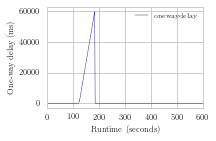

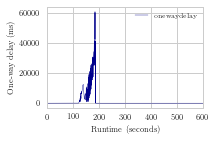

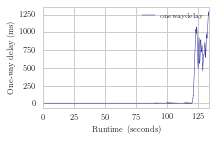

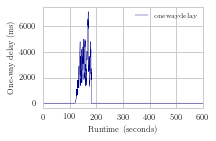

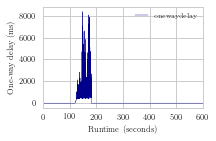

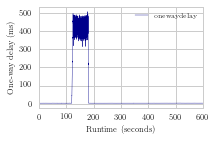

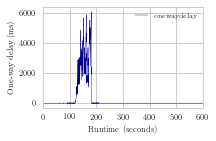

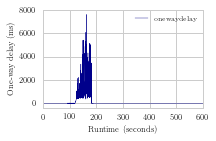

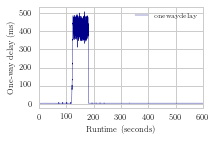

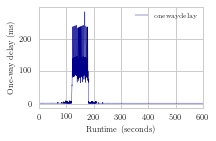

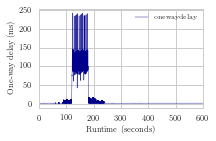

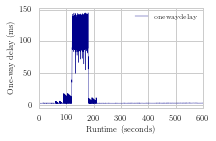

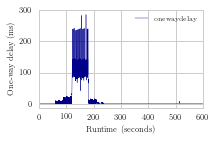

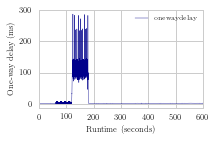

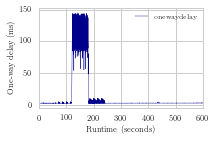

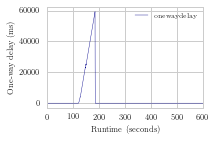

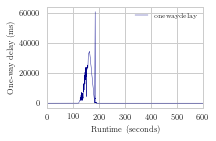

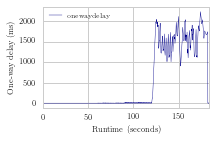

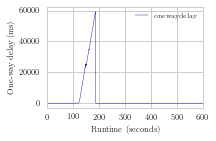

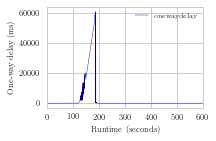

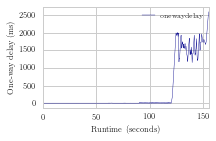

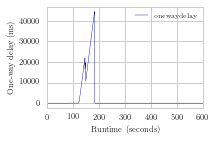

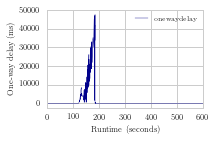

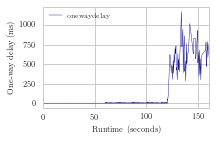

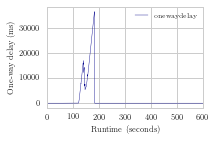

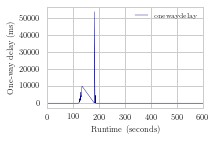

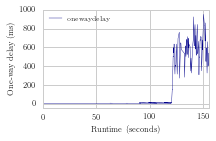

In [7]:
#Single Experiment
# DRR: one-way-delay over time
model='ct-drr' #(ct-)ge or random or ct-drr
for f in glob.iglob('./'+model+'/*030*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msg_number'])
    
    dfKPI = pd.read_csv(f+'firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    
    fig = dfapp.plot(x="seconds_offset", y="onewaydelay", marker="x", color="DarkBlue")
    
    fig.set_xlabel('Runtime (seconds)')
    fig.set_ylabel('One-way delay (ms)')
    plt.tight_layout()
    plt.savefig(f+"one-way-delay.pdf")

./ct-drr\20200304-1349-htb-drr--non-ephemeral\
./ct-drr\20200304-1359-htb-drr--light-ephemeral\
./ct-drr\20200304-1402-htb-drr--full-ephemeral\
./ct-drr\20200305-0846-htb-drr--non-ephemeral-quantum110\
./ct-drr\20200305-0857-htb-drr--light-ephemeral-quantum110\
./ct-drr\20200305-0907-htb-drr--full-ephemeral-quantum110\
./ct-drr\20200305-0930-htb-drr--non-ephemeral-quantum110\
./ct-drr\20200305-0940-htb-drr--light-ephemeral-quantum110\
./ct-drr\20200305-0950-htb-drr--full-ephemeral-quantum110\
./ct-drr\20200305-1028-htb-drr--non-ephemeral-quantum150\
./ct-drr\20200305-1039-htb-drr--light-ephemeral-quantum150\
./ct-drr\20200305-1049-htb-drr--full-ephemeral-quantum150\
./ct-drr\20200305-1131-htb-drr--non-ephemeral-quantum150\
./ct-drr\20200305-1141-htb-drr--light-ephemeral-quantum150\
./ct-drr\20200305-1152-htb-drr--full-ephemeral-quantum150\
./ct-drr\20200305-1233-htb-drr--non-ephemeral-qlim10-quantum55\
./ct-drr\20200305-1243-htb-drr--light-ephemeral-qlim10-quantum55\
./ct-drr\20200305-

C:\Users\Timo\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


./ct-drr\20200305-1328-htb-drr--non-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1338-htb-drr--light-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1341-htb-drr--full-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1403-htb-drr--non-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1413-htb-drr--light-ephemeral-qlim3-quantum55\
./ct-drr\20200305-1416-htb-drr--full-ephemeral-qlim3-quantum55\


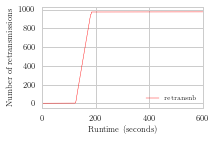

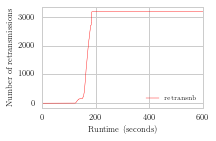

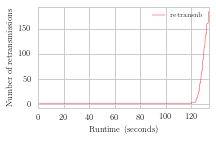

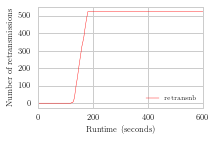

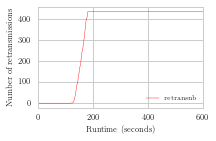

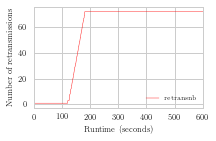

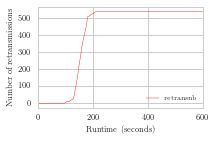

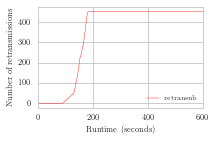

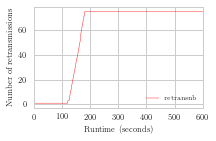

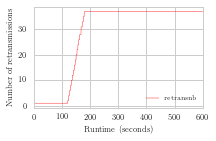

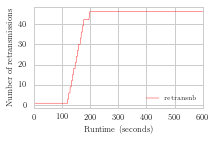

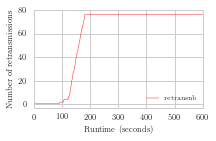

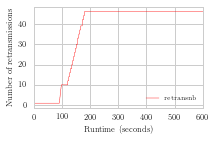

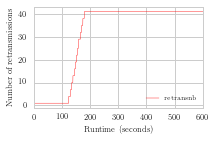

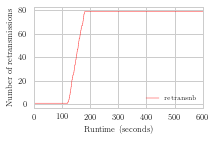

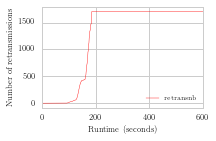

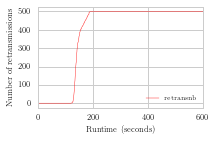

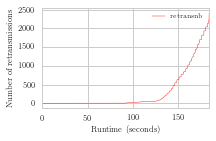

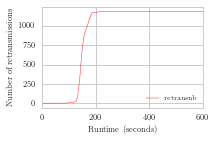

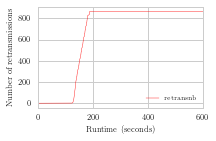

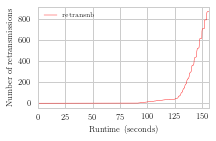

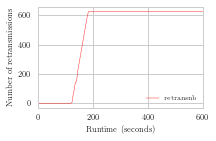

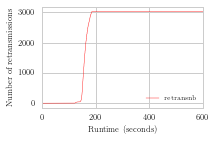

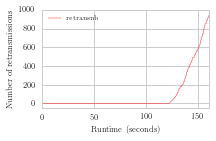

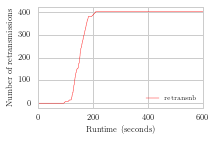

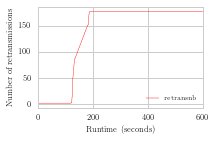

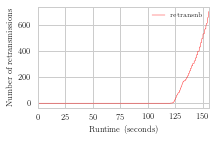

In [8]:
#Single Experiment
# DRR: retransmits over time
model='ct-drr' #(ct-)ge or random or ct-drr
for f in glob.iglob('./'+model+'/*030*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msg_number'])
    
    dfKPI = pd.read_csv(f+'firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    fig = dfKPI.plot(x="seconds_offset", y="retransnb", marker="x", color="red")
    
    fig.set_xlabel('Runtime (seconds)')
    fig.set_ylabel('Number of retransmissions')
    plt.tight_layout()
    plt.savefig(f+"retransmissions.pdf")

In [9]:
#Single Experiment
# DRR: message numbers
model='ct-drr' #(ct-)ge or random or ct-drr
for f in glob.iglob('./'+model+'/*030*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msgnumber', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msgnumber', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msgnumber'])
    
    title=f
    del dfapp['length']
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    sortedOneWayDelay = dfapp['onewaydelay'].sort_values()
    #print(sortedOneWayDelay.size)
    
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfapp.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)
            
    if(outdated.size == 0):
        outdatedsize=0; 
        outdatedmin=0;
        outdatedmean=0;
        outdatedmax=0;
    else:
        outdatedsize= outdated.size;
        outdatedmin=outdated.min();
        outdatedmean=outdated.mean();
        outdatedmax=outdated.max();
        
    print('Outdated:', outdatedsize, 'min:', outdatedmin, 'mean:', outdatedmean, 'median:', outdated.median(), 'max:', outdatedmax, ' (all delays in ms)')
    print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)\n')
    
    #fig = dfclient.plot(x="msgnumber", y="seconds_offset", marker="x", color="red", ms="1", linestyle='None')
    
    #x1=dfapp.msgnumber
    #y1=dfapp.seconds_offset
    #plt.plot(x1,y1, 'b+', ms='1') #app output
    
    #x2=dfstream.msgnumber
    #y2=dfstream.seconds_offset
    #plt.plot(x2,y2, 'k+', ms='1') #
    
    #plt.legend(['Client', 'S: app-level', 'S: stream-level'])
    
    #fig.set_ylabel('Runtime (seconds)')
    #fig.set_xlabel('Message Number')
    #plt.tight_layout()
    #plt.savefig(f+"msgnumber.pdf")

./ct-drr\20200304-1349-htb-drr--non-ephemeral\
Outdated: 62 min: 129.872 mean: 36965.69661290322 median: 57072.3205 max: 59802.046  (all delays in ms)
MsgsInTime: 5368 min: 2.648 mean: 2.950002608047669 median: 2.719 max: 94.791  (all delays in ms)

./ct-drr\20200304-1359-htb-drr--light-ephemeral\
Outdated: 625 min: 105.122 mean: 11791.844804800005 median: 3227.751 max: 61140.905  (all delays in ms)
MsgsInTime: 5355 min: 2.685 mean: 3.290674323062562 median: 2.886 max: 79.691  (all delays in ms)

./ct-drr\20200304-1402-htb-drr--full-ephemeral\
Outdated: 59 min: 108.995 mean: 807.6230508474579 median: 817.842 max: 1293.205  (all delays in ms)
MsgsInTime: 1208 min: 2.682 mean: 3.1863435430463576 median: 2.8235 max: 65.791  (all delays in ms)

./ct-drr\20200305-0846-htb-drr--non-ephemeral-quantum110\
Outdated: 549 min: 102.048 mean: 2656.3078123861574 median: 2537.854 max: 7150.051  (all delays in ms)
MsgsInTime: 5402 min: 2.652 mean: 2.987168085894102 median: 2.723 max: 99.229  (all dela

In [10]:
#Single Experiment
# DRR: message numbers debugging
model='ct-drr' #(ct-)ge or random or ct-drr
                                #*0227*
for f in glob.iglob('./'+model+'/*030*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msgnumber', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msgnumber', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msgnumber'])
    
    title=f
    del dfapp['length']
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    sortedOneWayDelay = dfapp['onewaydelay'].sort_values()
    #print(sortedOneWayDelay.size)
    
    #missing msg numbers
    msgIDs = list(range(1,dfclient.msgnumber.max()))
    missingMsgNumbers = list(set(msgIDs) - set(dfclient.msgnumber.tolist()))
    if len(missingMsgNumbers) != 0: 
        print('Missing: ', len(missingMsgNumbers), 'from', min(missingMsgNumbers), 'to', max(missingMsgNumbers)) 
    else: 
        print('None missing')
    
    #msgs IDs in wrong stream
    if len(missingMsgNumbers) != 0:
        if 'non-ephemeral' not in f:
            dfclient['checkStreamID'] = dfclient['streamid'].div(4)
            dfclient.checkStreamID = dfclient.checkStreamID.eq(dfclient.msgnumber)
            print(dfclient[dfclient['checkStreamID'] == False])
        else:
            print(missingMsgNumbers)
            print(dfclient[dfclient['msgnumber'] == min(missingMsgNumbers)-1])
            print(dfclient[dfclient['msgnumber'] == max(missingMsgNumbers)+1])
        
    print('')
        

./ct-drr\20200304-1349-htb-drr--non-ephemeral\
Missing:  570 from 1267 to 1837
[1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 14

./ct-drr\20200305-0930-htb-drr--non-ephemeral-quantum110\
Missing:  45 from 1348 to 1796
[1409, 1537, 1795, 1796, 1541, 1680, 1427, 1683, 1559, 1693, 1566, 1698, 1699, 1446, 1591, 1464, 1725, 1598, 1599, 1348, 1604, 1605, 1733, 1353, 1354, 1483, 1618, 1494, 1495, 1496, 1622, 1625, 1501, 1502, 1631, 1378, 1508, 1638, 1383, 1384, 1770, 1657, 1788, 1534, 1663]
      seconds_offset  streamid  msgnumber
1418      134.719549         4       1347
1429      135.284867         4       1347
      seconds_offset  streamid  msgnumber
2249      179.777194         4       1797

./ct-drr\20200305-0940-htb-drr--light-ephemeral-quantum110\
Missing:  104 from 1374 to 1796
      seconds_offset  streamid  msgnumber  checkStreamID
1470      137.550420      5496       1375          False
1479      138.190830      5496       1375          False
1481      138.190875      5520       1381          False
1484      138.338031      5528       1383          False
1490      138.879379      5548       1388          F

./ct-drr\20200305-1338-htb-drr--light-ephemeral-qlim3-quantum55\
Missing:  435 from 1234 to 1839
      seconds_offset  streamid  msgnumber  checkStreamID
1246      123.586979      4936       1235          False
1248      123.782382      4944       1237          False
1251      124.221696      4964       1242          False
1252      124.221698      4960       1242          False
1253      124.221701      4956       1242          False
1254      124.221703      4952       1242          False
1263      124.722031      4936       1235          False
1265      125.410750      4964       1242          False
1266      125.410753      4960       1242          False
1267      125.410756      4956       1242          False
1268      125.410758      4952       1242          False
1271      125.410897      5008       1253          False
1272      125.410899      5004       1253          False
1273      125.410906      5000       1253          False
1274      125.410909      4996       1253       

In [ ]:
# all three versions in one figure
fN='20200227-1757-htb-drr--non-ephemeral-htb-drr-mqs100-qlim5'
fL='20200227-1807-htb-drr--light-ephemeral-htb-drr-mqs100-qlim5'
fF='20200227-1810-htb-drr--full-ephemeral-htb-drr-mqs100-qlim5'

dfN = pd.read_csv('./ct-drr/'+fN+'/serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
dfL = pd.read_csv('./ct-drr/'+fL+'/serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
dfF = pd.read_csv('./ct-drr/'+fF+'/serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])

dfN.onewaydelay = dfN.onewaydelay.apply(lambda x: x / 1000) # from us to ms
dfL.onewaydelay = dfL.onewaydelay.apply(lambda x: x / 1000) # from us to ms
dfF.onewaydelay = dfF.onewaydelay.apply(lambda x: x / 1000) # from us to ms

x1=dfN.seconds_offset
x2=dfL.seconds_offset
x3=dfF.seconds_offset
y1=dfN.onewaydelay
y2=dfL.onewaydelay
y3=dfF.onewaydelay

plt.plot(x1,y1, 'b-'),
plt.plot(x2,y2, 'g-'),
plt.plot(x3,y3,'y:'),
#plt.plot(x2,y4,'k:'),

#plt.gca().set_ylim([-200,4000])
plt.gca().set_xlim([-1,300])
plt.axvline(x=30, ymax=0.1, color='k', ls='--')
plt.axvline(x=60, ymax=0.1, color='k', ls='--')
plt.axvline(x=90, ymax=0.1, color='k', ls='--')
plt.axvline(x=120, ymax=0.1, color='k', ls='--')
plt.axvline(x=180, ymax=0.1, color='k')
plt.axvline(x=210, ymax=0.1, color='k')
plt.axvline(x=240, ymax=0.1, color='k')
plt.axvline(x=270, ymax=0.1, color='k')

plt.legend(['non-ephemeral', 'light-ephemeral', 'full-ephemeral']),
plt.xlabel('Runtime (seconds)'),
plt.ylabel('One-way delay (ms)'),

plt.tight_layout()
plt.savefig('./ct-drr/'+fF+'/one-way-delay_all.pdf')


In [ ]:
#use from cell above!
#fN='20200204-1448-htb-drr--non-ephemeral-55-500'
#fL='20200204-1458-htb-drr--light-ephemeral-55-500'
#fF='20200204-1509-htb-drr--full-ephemeral-55-500'

dfN = pd.read_csv('./ct-drr/'+fN+'/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','msgnumber', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfL = pd.read_csv('./ct-drr/'+fL+'/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','msgnumber', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfF = pd.read_csv('./ct-drr/'+fF+'/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','msgnumber', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])

x1=dfN.seconds_offset
x2=dfL.seconds_offset
x3=dfF.seconds_offset
y1=dfN.retransnb
y2=dfL.retransnb
y3=dfF.retransnb

plt.plot(x1,y1, 'b-'),
plt.plot(x2,y2, 'g-'),
plt.plot(x3,y3,'y:'),
#plt.plot(x2,y4,'k:'),

#plt.gca().set_ylim([-200,4000])
plt.gca().set_xlim([-1,300])
plt.axvline(x=30, ymax=0.1, color='k', ls='--')
plt.axvline(x=60, ymax=0.1, color='k', ls='--')
plt.axvline(x=90, ymax=0.1, color='k', ls='--')
plt.axvline(x=120, ymax=0.1, color='k', ls='--')
plt.axvline(x=180, ymax=0.1, color='k')
plt.axvline(x=210, ymax=0.1, color='k')
plt.axvline(x=240, ymax=0.1, color='k')
plt.axvline(x=270, ymax=0.1, color='k')

plt.legend(['non-ephemeral', 'light-ephemeral', 'full-ephemeral']),
plt.xlabel('Runtime (seconds)'),
plt.ylabel('Number of Retransmissions'),

plt.tight_layout()
plt.savefig('./ct-drr/'+fF+'/retransmissions_all.pdf')

In [ ]:
# use from above 2 cells
#fN='20200204-1233-htb-drr--non-ephemeral-55-1400'
#fL='20200204-1243-htb-drr--light-ephemeral-55-1400'
#fF='20200204-1254-htb-drr--full-ephemeral-55-1400'

dfN = pd.read_csv('./ct-drr/'+fN+'/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','msgnumber', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfL = pd.read_csv('./ct-drr/'+fL+'/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','msgnumber', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfF = pd.read_csv('./ct-drr/'+fF+'/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'retransnb', 
                                                        'rtt_min', 'current_rtt', 'send_time','msgnumber', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])

dfN.current_rtt = dfN.current_rtt.apply(lambda x: x / 1000) # from us to ms
dfL.current_rtt = dfL.current_rtt.apply(lambda x: x / 1000) # from us to ms
dfF.current_rtt = dfF.current_rtt.apply(lambda x: x / 1000) # from us to ms

x1=dfN.seconds_offset
x2=dfL.seconds_offset
x3=dfF.seconds_offset
y1=dfN.current_rtt
y2=dfL.current_rtt
y3=dfF.current_rtt

plt.plot(x1,y1, 'b-'),
plt.plot(x2,y2, 'g-'),
plt.plot(x3,y3,'y:'),
#plt.plot(x2,y4,'k:'),

#plt.gca().set_ylim([-200,4000])
plt.gca().set_xlim([-1,300])
plt.axvline(x=30, ymax=0.1, color='k', ls='--')
plt.axvline(x=60, ymax=0.1, color='k', ls='--')
plt.axvline(x=90, ymax=0.1, color='k', ls='--')
plt.axvline(x=120, ymax=0.1, color='k', ls='--')
plt.axvline(x=180, ymax=0.1, color='k')
plt.axvline(x=210, ymax=0.1, color='k')
plt.axvline(x=240, ymax=0.1, color='k')
plt.axvline(x=270, ymax=0.1, color='k')

plt.legend(['non-ephemeral', 'light-ephemeral', 'full-ephemeral']),
plt.xlabel('Runtime (seconds)'),
plt.ylabel('Current RTT \n perceived at client (ms)'),

plt.tight_layout()
plt.savefig('./ct-drr/'+fF+'/currentRTT_all.pdf')

In [ ]:
#print('Non-Ephemeral\n', dfNE)#, '\nLight-Ephemeral\n', dfLE, '\nFull-Ephemeral\n', dfFE)

#print(matplotlib.rcParams)

dfNE['Version'] = 'N'
dfLE['Version'] = 'L'
dfFE['Version'] = 'F'
dfAll = pd.concat([dfNE, dfLE, dfFE])
dfAll = dfAll[dfAll['lossrate']!=1] # delete possible 1% lossrate runs
#print(dfAll)

boxprops=dict(linewidth=0.4, color="black") #coloring here does not work
medianprops=dict(linewidth=0.4, color="black")
whiskerprops=dict(linewidth=0.4, color='black')
capprops=dict(linewidth=0.1, color="black")
flierprops=dict(marker='x', markeredgecolor='k', markersize=1)

fig = dfAll.boxplot(column='inTime', by=['lossrate', 'Version'], boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, flierprops=flierprops, showfliers=False, patch_artist=True)


plt.title('')
plt.suptitle('')


for i, obj in enumerate(fig.findobj(matplotlib.patches.Patch)):
    if i>14:
        break;
    #print(i, obj, obj.get_path())
    if (i%3) == 0: 
        obj.set_facecolor("salmon")
        #print(obj.get_edgecolor())
        obj.set_edgecolor("black") # does work, but still the line is blue
    else:
        if (i%3) == 1:
            obj.set_facecolor("gold")
            obj.set_edgecolor("black")
        else:
            obj.set_facecolor("c")
            obj.set_edgecolor("black")
            
            
if '1' in dfAll.lossrate:
    plt.xticks([2, 5, 8, 11, 14], [1, 2, 4, 8, 16])
else:
    plt.xticks([2, 5, 8, 11], [2, 4, 8, 16])

fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('In-time\nmessages received')
plt.tight_layout()
plt.savefig(f+model+"_msgs_intime_boxplot.pdf")

In [ ]:
#CCDFs
# one-way delay (stream layer)
for f in glob.iglob('./crosstraffic_mqs-6/*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfstream['length']
    print(f)
    
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    sortedOneWayDelay = dfstream['onewaydelay'].sort_values()
    print(sortedOneWayDelay.size)
    
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfstream.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)
            
    print('Outdated:', outdated.size, 'min:', outdated.min(), 'mean:', outdated.mean(), 
            'median:', outdated.median(), 'max:', outdated.max(), ' (all delays in ms)')
    print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
            'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)\n')
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedOneWayDelay))
    cdf = pd.Series(cum_dist, index=sortedOneWayDelay)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Delay of packets (ms)')
    fig.set_yscale('log')
    plt.tight_layout()
    plt.savefig(f+"ccdf_one-way-delay_stream.pdf")

In [ ]:
''' 
# for every version: 
# compute mean, and get min and max for every lossrate over all runs
# plot the mean, with errorbar yerr=max-min

dfAll = pd.DataFrame()
dfAll['NE-inTime-mean'] = dfNE.groupby('lossrate')['inTime'].mean()
dfAll['NE-inTime-max'] = dfNE.groupby('lossrate')['inTime'].max()
dfAll['NE-inTime-min'] = dfNE.groupby('lossrate')['inTime'].min()
dfAll['NE-inTime-var'] = dfAll['NE-inTime-max']-dfAll['NE-inTime-min']

dfAll['LE-inTime-mean'] = dfLE.groupby('lossrate')['inTime'].mean()
dfAll['LE-inTime-max'] = dfLE.groupby('lossrate')['inTime'].max()
dfAll['LE-inTime-min'] = dfLE.groupby('lossrate')['inTime'].min()
dfAll['LE-inTime-var'] = dfAll['LE-inTime-max']-dfAll['LE-inTime-min']

dfAll['FE-inTime-mean'] = dfFE.groupby('lossrate')['inTime'].mean()
dfAll['FE-inTime-max'] = dfFE.groupby('lossrate')['inTime'].max()
dfAll['FE-inTime-min'] = dfFE.groupby('lossrate')['inTime'].min()
dfAll['FE-inTime-var'] = dfAll['FE-inTime-max']-dfAll['FE-inTime-min']

dfAll.reset_index(inplace=True)
print(dfAll)

cap=2; #capsize for errorbars
mark=1; #markersize for plots
lin='None';
shift=0.25


# messages received in time with variance
    fig = dfAll.plot(x="lossrate", y="LE-inTime-mean", kind='scatter', color="y", s=1)
    
    x = dfAll.lossrate.apply(lambda x: x-shift)
    y = dfAll['NE-inTime-mean']
    yerr = dfAll['NE-inTime-var']
    fig.plot(x, y, 'b', marker="o", ms=mark, color='b', ls=lin)
    fig.errorbar(x, y, yerr, capsize=cap, ls=lin)
    
    x1 = dfAll.lossrate
    y1 = dfAll['LE-inTime-mean']
    yerr1 = dfAll['LE-inTime-var']
    fig.plot(x1, y1, 'y', marker="v", ms=mark, ls=lin)
    fig.errorbar(x1, y1, yerr1, capsize=cap, color='y', ls=lin)
    
    x2 = dfAll.lossrate.apply(lambda x: x+shift)
    y2 = dfAll['FE-inTime-mean']
    yerr2 = dfAll['FE-inTime-var']
    fig.plot(x2, y2, 'r', marker="D", ms=mark, ls=lin)
    fig.errorbar(x2, y2, yerr2, capsize=cap, color='r', ls=lin)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")
    
    #fig.set_xscale('log')
    plt.xticks(dfAll.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('In-time\nmessages received')
    plt.tight_layout()
    plt.savefig(f+"msgs_intime+variance.pdf")'''

In [ ]:
# outdated holes
# 1. STREAM LEVEL 
# 2. APP LEVEL
# msgs consecutively lost (holes)
for f in glob.iglob('./*20191204*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfstream['length']
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    diffList = []; # [difference, n1, n2] -> when negative, outdated data. When positive, hole
                # !! when APP not STREAM used, than non-ephemeral has no holes since it reorders on app-level
   
    outdatedList = []; # how many outdated messages were processed
    
    holeList = []; # how big are the data holes
    holeTimeList = []; # what are sizes of the holes in time
    
    for i, number in enumerate(dfstream['msg_number']):
        if i+1 < dfstream.msg_number.size:
            n1 = dfstream.msg_number[i]
            n2 = dfstream.msg_number[i+1]
            if n2 != n1+1:
                timedDiff=0
                if(n2 > n1):
                    timedDiff = dfapp.seconds_offset[i+1]*1000 - dfapp.seconds_offset[i]*1000
                    holeTimeList.append(timedDiff)
                diffList.append([n2-n1, n1, n2])
                #print(n2-n1, n1, n2, str(timedDiff))
    
    for j in diffList:
        if j[0] < 0:
            outdatedList.append(j)
        else:
            holeList.append(j)
            
    outdated = pd.Series(i[0] for i in outdatedList)
    holes = pd.Series(i[0] for i in holeList)
    holeTimes = pd.Series(holeTimeList)
    print('# STREAM LEVEL')
    print('Outdated by: min=', outdated.min(), 'mean=', outdated.mean(), 'median=', outdated.median(), 'max=', outdated.max(), 'occurences=', outdated.size)
    print('Hole times: min=', holeTimes.min(), 'mean=', holeTimes.mean(), 'median=', holeTimes.median(), 'max=', holeTimes.max(), 'occurences=', holeTimes.size)
    print('Hole sizes: min=', holes.min(), 'mean=', holes.mean(), 'median=', holes.median(), 'max=', holes.max(), 'occurences=', holes.size, '\n')
    
    
    #APP LEVEL
    print('# APP LEVEL')

    #delete every outdated packet at first?
    filtered = [];
    for sec in dfapp[dfapp['onewaydelay'] < 100].seconds_offset:
        filtered.append(sec);
    
    holeDetect = [];
    for i, seconds in enumerate(filtered):
        if i+1 < len(filtered):
            t1 = filtered[i]
            t2 = filtered[i+1]
            if t2-t1 > 0.2:
                holeDetect.append([filtered[i], filtered[i+1], (t2-t1)*1000])
                #print((t2-t1)*1000)
    
    holeTimesApp = pd.Series(i[2] for i in holeDetect)
    print('Hole sizes (ms) [filtered]: min=', holeTimesApp.min(), 'mean=', holeTimesApp.mean(), 'median=', holeTimesApp.median(), 
          'max=', holeTimesApp.max(), 'occurences=', holeTimesApp.size)
    
    holeDetect = [];
    for i, seconds in enumerate(dfapp.seconds_offset):
        if i+1 < len(dfapp.seconds_offset):
            t1 = dfapp.seconds_offset[i]
            t2 = dfapp.seconds_offset[i+1]
            if t2-t1 > 0.2:
                holeDetect.append([dfapp.seconds_offset[i], dfapp.seconds_offset[i+1], (t2-t1)*1000])
                #print((t2-t1)*1000)
    
    holeTimesApp = pd.Series(i[2] for i in holeDetect)
    print('Hole sizes (ms) [unfiltered]: min=', holeTimesApp.min(), 'mean=', holeTimesApp.mean(), 'median=', holeTimesApp.median(), 
          'max=', holeTimesApp.max(), 'occurences=', holeTimesApp.size, '\n')

In [ ]:
#CCDFs
# time between consecutive msgs (should be under the deadline)
for f in glob.iglob('./*20191203*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfapp['length']
    print(f)
    
    #compute the time between two consecutive packets
    dfapp.sort_values(by='msg_number')
    dfapp['ms_offset'] = dfapp.seconds_offset.apply(lambda x: x * 1000) # from s to ms
    #print(dfapp)
    
    i = dfapp.ms_offset[0];
    timeBetween = [];
    for j in dfapp['ms_offset']:
        timeBetween.append(j-i)
        i = j
        
    dfapp['timeBetweenMsgs'] = timeBetween
    sortedTimesBetweenMsgs = dfapp['timeBetweenMsgs'].sort_values()
    #print(sortedTimesBetweenMsgs)
    #print(dfapp.sort_values(by='timeBetweenMsgs'))
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedTimesBetweenMsgs))
    cdf = pd.Series(cum_dist, index=sortedTimesBetweenMsgs)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between packets (ms)')
    #fig.set_yscale('log')
    plt.tight_layout()
    plt.savefig(f+"ccdf_timeBetweenMsgs.pdf")

In [ ]:
#CCDFs
# time between actual msgs arrival and perfect arrical time
for f in glob.iglob('./*20191203*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfapp['length']
    
    #compute the time between actual arrival time and perfect arrival time
    dfapp.sort_values(by='msg_number')
    
    #starttime = dfapp.seconds_offset[0] - 0.1
    #print(starttime)
    
    dfapp['ms_offset'] = dfapp.seconds_offset.apply(lambda x: x * 1000) # from s to ms
    dfapp['perfectTimeDeviation'] = dfapp.ms_offset - dfapp.msg_number * 100
    #print(dfapp)

    sortedTimeDeviation = dfapp['perfectTimeDeviation'].sort_values()
    #print(sortedTimeDeviation)
    #print(dfapp)
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedTimeDeviation))
    cdf = pd.Series(cum_dist, index=sortedTimeDeviation)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between actual arrival \n and perfect arrival time (ms)')
    plt.tight_layout()
    
    #plt.savefig(f+"ccdf_perfectTimeDeviation.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"all_ccdf_perfectTimeDeviation_ylog.pdf")

In [ ]:
#PING: single experiment
#SCATTERPLOT - PING + rtt values over time
'''
for f in glob.iglob('./*1016-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'ack_delay', 'srtt', 'rtt_var', 'state'])
                                                        # KPIs FROM BEFORE 18.10.2019!
                                                        
    #dping = pd.read_csv('./20191015-1314_1hr_ping/20191015-1314_client_ping_grep', delim_whitespace=True, 
                        names = ['seconds_offset', 'ping_number', 'ping_rtt'])
    
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    print(df.current_rtt.mean(),
          df.srtt.mean(),
          dping.ping_rtt.mean())
    
    
    fig = dping.plot(x="ping_number", y="ping_rtt", kind='scatter', color="DarkBlue", s=0.01)
    x = df.seconds_offset
    y1 = df.current_rtt
    fig.plot(x,y1,'r:') # more examples = 'b:' 'k:' 'r--'
    y2 = df.srtt
    fig.plot(x,y2, 'y:')

    axes = plt.gca()
    fig.legend(['Current RTT', 'Smoothed RTT', 'Ping RTT'])
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing+ping.pdf")
    
    axes.set_ylim([0,250])
    #axes.set_xlim([-5,605])
    plt.savefig(f+"_timing+ping_limit.pdf")
'''

In [ ]:
#WiFi vs ETH
#BOXPLOT - application RTT (current rtt)
dfe100 = pd.read_csv('./analysis_wifi-vs-eth/eth_100ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
dfe200 = pd.read_csv('./analysis_wifi-vs-eth/eth_200ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfe500 = pd.read_csv('./analysis_wifi-vs-eth/eth_500ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw100 = pd.read_csv('./analysis_wifi-vs-eth/wifi_100ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw200 = pd.read_csv('./analysis_wifi-vs-eth/wifi_200ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw500 = pd.read_csv('./analysis_wifi-vs-eth/wifi_500ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])

dfe100 = dfe100[dfe100.index % 2 != 0]
dfe100 = dfe100[dfe100.state == 15]
dfe200 = dfe200[dfe200.index % 2 != 0]
dfe200 = dfe200[dfe200.state == 15]
dfe500 = dfe500[dfe500.index % 2 != 0]
dfe500 = dfe500[dfe500.state == 15]

dfw100 = dfw100[dfw100.index % 2 != 0]
dfw100 = dfw100[dfw100.state == 15]
dfw200 = dfw200[dfw200.index % 2 != 0]
dfw200 = dfw200[dfw200.state == 15]
dfw500 = dfw500[dfw500.index % 2 != 0]
dfw500 = dfw500[dfw500.state == 15]

df = pd.DataFrame()
df['dfe100'] = dfe100.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe200'] = dfe200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe500'] = dfe500.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw100'] = dfw100.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw200'] = dfw200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw500'] = dfw500.current_rtt.apply(lambda x: x / 1000) #from us to ms

print('Ethernet 100ms: ', df.dfe100.min(), '(min) ', df.dfe100.max(), '(max) ', df.dfe100.median(), '(median) ', '\n',
      'Ethernet 200ms: ', df.dfe100.min(), '(min) ', df.dfe200.max(), '(max) ', df.dfe200.median(), '(median) ', '\n',
      'Ethernet 500ms: ', df.dfe100.min(), '(min) ', df.dfe500.max(), '(max) ', df.dfe500.median(), '(median) ', '\n',
      'WiFi 100ms: ', df.dfw100.min(), '(min) ', df.dfw100.max(), '(max) ', df.dfw100.median(), '(median) ', '\n',
      'WiFi 200ms: ', df.dfw200.min(), '(min) ', df.dfw200.max(), '(max) ', df.dfw200.median(), '(median) ', '\n',
      'WiFi 500ms: ', df.dfw500.min(), '(min) ', df.dfw500.max(), '(max) ', df.dfw500.median(), '(median) ', '\n')


#print(df.to_string())

fig = df.boxplot(showfliers=True, flierprops={'markersize': 1, 'marker': 'x',
                                              'markerfacecolor': 'none', 'markeredgecolor': 'black'}) 
                #showfliers=False -> circles outside of the boxplot
    
fig.set_yscale('log')

plt.xticks([1, 2, 3, 4, 5, 6], ['100', '200\nEthernet\n(interval in ms)', '500', '100', '200\nWiFi\n(interval in ms)', '500'])
fig.set_ylabel('RTT (ms)')
plt.tight_layout()
plt.savefig("./analysis_wifi-vs-eth/rtt_boxplots_wifi-vs-eth_100-200-500ms_ylog_fliers.pdf")


In [ ]:
#WiFi vs ETH
#BOXPLOT - application RTT (current rtt)

dfw200 = pd.read_csv('./eth-vs-wifi/20191025-1451_200ms-5min_wifi_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw200_long = pd.read_csv('./eth-vs-wifi/20191023-1635_200ms-2hr_wifi_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfe200 = pd.read_csv('./eth-vs-wifi/20191029-1406_200ms-5min_eth_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 

df = pd.DataFrame()
df['dfw200_long'] = dfw200_long.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw200'] = dfw200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe200'] = dfe200.current_rtt.apply(lambda x: x / 1000) #from us to ms

print(df.to_string())

fig = df.boxplot()

plt.xticks([1, 2, 3], ['WiFi 200ms', 'WiFi 200ms', 'Eth 200ms'])
fig.set_ylabel('Time (ms)')
plt.tight_layout()
plt.savefig("./eth-vs-wifi/rtt_boxplots_200ms.pdf")


In [ ]:
#SCATTERPLOT - rtt values over time
for f in glob.iglob('./*1023-*200ms*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
        
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    df.rtt_min = df.rtt_min.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    print(df.current_rtt.mean(),
          df.srtt.mean())
    
    fig = df.plot(x="seconds_offset", y="rtt_min", kind='scatter', color="DarkBlue", s=0.01)
    x = df.seconds_offset
    y2 = df.srtt
    fig.plot(x,y2, 'y.')
    y1 = df.current_rtt
    fig.plot(x,y1, 'r.') # more examples = 'b:' 'k:' 'r--'

    axes = plt.gca()
    fig.legend(['Current RTT', 'Smoothed RTT', 'min RTT'])
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing.pdf")
    
    axes.set_ylim([0,25])
    #axes.set_xlim([-5,1000])
    plt.savefig(f+"_timing_limit.pdf")

In [ ]:
#BOXPLOTS - rtt values (Current RTT + Smoothed RTT)
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    #delete unnecessary data
    df.drop(['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 'rtt_min', 
             'send_time', 'reception_time', 'current_ackdelay', 'rtt_var','max_ackdelay', 'state'], axis=1, inplace=True)
    
    #delete initial values
    df.drop(df.index[0], inplace=True)
    
    fig = plt.figure() #this line makes a plot for every file
    fig = df.boxplot()
    plt.xticks([1, 2], ['Current RTT', 'Smoothed RTT'])
    fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing_boxplots.pdf")

In [ ]:
#SCATTERPLOT - congestion window
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    fig = df.plot(x="seconds_offset", y="cwin", marker=",", markersize="0.01", color="DarkBlue", linestyle="None")

    axes = plt.gca()
    #axes.set_ylim([0,20])
    #axes.set_xlim([-5,605])
    axes.get_legend().remove()
    
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Congestion Window')
    plt.tight_layout()
    plt.savefig(f+"_cwin.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"_cwin_ylog.pdf")

In [ ]:
#SCATTERPLOT retransmissions over time
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.state.count())
    print(num_retrans, "\n")
    
    fig = df.plot(x="seconds_offset", y="state", marker="x", markersize="0.1", color="DarkBlue", linestyle="None")
    
    fig.text(df['seconds_offset'].max()*0.75, 0.95, num_retrans, horizontalalignment='center', verticalalignment='center')
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Retransmission=1')
    plt.tight_layout()
    plt.savefig(f+"_retransOverTime.pdf")


In [ ]:
# CUMULATIVE DISTRIBUTION FUNCTION - time between retransmissions
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    
    #delete the normal (no-retransmission) packets
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.seconds_offset.count())
    print(num_retrans, "\n")
    
    #compute the time between retransmissions
    i = 0;
    timeBetween = [];
    for j in df['seconds_offset']:
        timeBetween.append(j-i)
        i = j
        
    df['timeBetween'] = timeBetween
    sortedRetrans = df['timeBetween'].sort_values()
    #print(sortedRetrans)
    #print(df.seconds_offset)
    
    #build the CDF
    cum_dist = np.linspace(0.,1.,len(sortedRetrans))
    cdf = pd.Series(cum_dist, index=sortedRetrans)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    fig.text(sortedRetrans.max()*0.75, 0, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between retransmissions (s)')
    plt.tight_layout()
    plt.savefig(f+"_cdf_retransTimeBetween.pdf")


In [ ]:
# COMPLEMENTARY CUMULATIVE DISTRIBUTION FUNCTION - time between retransmissions
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    
    #delete the normal (no-retransmission) packets
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.seconds_offset.count())
    print(num_retrans, "\n")
    
    #compute the time between retransmissions
    i = 0;
    timeBetween = [];
    for j in df['seconds_offset']:
        timeBetween.append(j-i)
        i = j
        
    df['timeBetween'] = timeBetween
    sortedRetrans = df['timeBetween'].sort_values()
    #print(sortedRetrans)
    #print(df.seconds_offset)
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedRetrans))
    cdf = pd.Series(cum_dist, index=sortedRetrans)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between retransmissions (s)')
    plt.tight_layout()
    plt.savefig(f+"_ccdf_retransTimeBetween.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"_ccdf_retransTimeBetween_ylog.pdf")
    
    axes = plt.gca() 
    axes.set_xlim([0,100])
    fig.text(60, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')
    plt.savefig(f+"_ccdf_retransTimeBetween_yloglim.pdf")

In [ ]:
#SCATTERPLOT - rtt values over time
#COMPARISON to TIMING VALUES
for f in glob.iglob('./*1023-*200*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    #calculate the comparison value
    df['recept_send'] = df.reception_time - df.send_time
    df['deviation'] = df.recept_send - df.current_rtt
    df = df[df.state == 15] #only values after successful start are comparable (earlier, there is no send or reception time set)
    
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    df.rtt_min = df.rtt_min.apply(lambda x: x / 1000)
    df.recept_send = df.recept_send.apply(lambda x: x / 1000)
    df.deviation = df.deviation.apply(lambda x: x / 1000)
    df.current_ackdelay = df.current_ackdelay.apply(lambda x: x / 1000)
    df.max_ackdelay = df.max_ackdelay.apply(lambda x: x / 1000)
    
    title=f
    print(f)
    
    print('Current RTT mean: ' + str(df.current_rtt.mean()) + '\n',
          'SRTT mean: ' + str(df.srtt.mean()) + '\n',
         'Calculated reception-send mean: ' + str(df.recept_send.mean()) + '\n',
         'Deviation mean: ' + str(df.deviation.mean()) + '\n')
    
    standard = 0; #1 = standard plot over time
                  #0 = deviation plotted over time
    
    if(standard):
        fig = df.plot(x="seconds_offset", y="rtt_min", kind='scatter', color="DarkBlue", s=0.01)
        x = df.seconds_offset
        y1 = df.current_rtt
        fig.plot(x,y1,'r:') # more examples = 'b:' 'k:' 'r--'
        y2 = df.recept_send
        fig.plot(x,y2, 'y:')

        axes = plt.gca()
        fig.legend(['Current RTT', 'recept minus send', 'min RTT'])
        fig.set_xlabel('Runtime (seconds)')
        lines = fig.set_ylabel('Time (ms)')
        plt.tight_layout()
        plt.savefig(f+"_timing-comparison.pdf")
    
    #Plotting only deviation values
    else:
        df['deviation'] = df['deviation'].replace(0.0, np.nan) #set all 0.0 to NaN -> not plotted
        df.dropna(inplace=True)
        print(df[['seconds_offset', 'current_rtt', 'recept_send', 
                  'deviation', 'current_ackdelay', 'max_ackdelay']].to_string(index=False))

        fig = df.plot(x="seconds_offset", y="deviation", kind='scatter', color="DarkBlue", s=0.01)
        x = df.seconds_offset
        
        num_deviations = 'Differences = ' + str(df.deviation.count())
        print(num_deviations, "\n")
        #fig.text(df.seconds_offset.max()*0.9, df.deviation.max()*0.9, num_deviations, horizontalalignment='center', verticalalignment='center')

        axes = plt.gca()
        fig.legend(['Deviation'])
        fig.set_xlabel('Runtime (seconds)  [' + num_deviations + ']')
        lines = fig.set_ylabel('Time (ms)')
        plt.tight_layout()
        plt.savefig(f+"_timing-deviation_cleaned.pdf")

In [ ]:
#SINGLE EXPERIMENT
# Compute the time from pcap files
# Comparison with current_rtt from application

for f in glob.iglob('./*1029-08*/*client_filter_pcap', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, float_precision='round_trip', names = ['seconds_offset', 'framenumber', 'datasize']) 
                                                        #extraction of PCAP: update from 28.10.19
    title=f
    print(f)
    
    dfserver = pd.read_csv('./20191029-0810_500ms-5min_pcap2_eth/server_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])
    
    #TODO: Cut firstKPIs short to cover only the same packets as in filtered PCAP
    dfcomp = pd.read_csv('./20191029-0810_500ms-5min_pcap2_eth/firstKPIs', delim_whitespace=True, 
                        names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                 'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                 'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
    
    #set the indices
    i=0
    j=1
    k=2
    
    rtt1 = []
    rtt2 = []
    frameNumber = []
    frameNumber1 = []
    frameNumber2 = []
    dataSize1 = []
    dataSize2 = []
    
    
    client2server = []
    server2client = []
    serverprocessingtime = []
    
    num_packets = df.seconds_offset.count()/3

    #compute the pcap rtt's: first reply - request = rtt1, 
    #                        second reply - request = rtt2,
    #                        server_receive - client_sent
    for x in range(num_packets.astype(int)):
        frameNumber.append(df.at[i, 'framenumber'])
        rtt1.append(df.at[j, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        frameNumber1.append(df.at[j, 'framenumber'])
        dataSize1.append(df.at[j, 'datasize'])
        rtt2.append(df.at[k, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        frameNumber2.append(df.at[k, 'framenumber'])
        dataSize2.append(df.at[k, 'datasize'])
        
        client2server.append(dfserver.at[i, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        serverprocessingtime.append(dfserver.at[j, 'seconds_offset'] - dfserver.at[i, 'seconds_offset'])
        server2client.append(df.at[j, 'seconds_offset'] - dfserver.at[j, 'seconds_offset'])
        
        i=i+3
        j=j+3
        k=k+3
        
    
    df2 = pd.DataFrame()
    df2['frame'] = frameNumber
    df2['app_rtt'] = dfcomp['current_rtt']
    df2['clientrtt1'] = rtt1
    #df2['frame+1'] = frameNumber1
    #df2['size1'] = dataSize1
    #df2['client_rtt2'] = rtt2
    #df2['frame+2'] = frameNumber2
    #df2['size2'] = dataSize2
    
    df2['client2server'] = client2server
    df2['server2client'] = server2client
    df2['serverprocessingtime'] = serverprocessingtime
    
    df2.app_rtt = df2.app_rtt.apply(lambda x: x / 1000) #from us to ms
    df2.clientrtt1 = df2.clientrtt1.apply(lambda x: x * 1000) #from s to ms
    #df2.client_rtt2 = df2.client_rtt2.apply(lambda x: x * 1000)
    df2.client2server = df2.client2server.apply(lambda x: x * 1000)
    df2.server2client = df2.server2client.apply(lambda x: x * 1000)
    df2.serverprocessingtime = df2.serverprocessingtime.apply(lambda x: x * 1000)
    
    print(df2.to_string())
    
    fig = df2.plot(x="frame", y="clientrtt1", kind='line', color="DarkBlue", linestyle=':')
    
    
    fig.set_xlabel('packet number')
    fig.set_ylabel('measured time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_analysis.pdf")

In [ ]:
#iperf UDP

dfserver = pd.read_csv('./iperf_tests/20191028-1019_udp/server_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])
dfclient = pd.read_csv('./iperf_tests/20191028-1019_udp/client_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])

client2server = []
clienttime = []
client_firstoffset = dfclient.at[0, 'seconds_offset']
servertime = []

for x in range(dfclient.seconds_offset.count()):
    client2server.append(dfserver.at[x, 'seconds_offset'] - dfclient.at[x, 'seconds_offset'])
    #clienttime.append(dfclient.at[x, 'seconds_offset'] - client_firstoffset)
    #servertime.append(dfserver.at[x, 'seconds_offset'] - client_firstoffset)
    

df = pd.DataFrame()
#df['client_time'] = clienttime
#df['server_time'] = servertime
df['client2server'] = client2server

df.client2server = df.client2server.apply(lambda x: x * 1000) #from s to ms


print(df.to_string())


#fig = df.plot()

#fig.set_xlabel('index')
#fig.set_ylabel('measured time (ms)')
#plt.tight_layout()
#plt.savefig("./iperf_tests/20191028-1019_udp/client_filter_pcap_analysis.pdf")

In [ ]:
#iperf TCP

dfserver = pd.read_csv('./iperf_tests/20191029-1136_tcp/server_filter_pcap_acks', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'rtt'])
dfclient = pd.read_csv('./iperf_tests/20191029-1136_tcp/client_filter_pcap_acks', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'rtt'])

dfclient = dfclient.apply(lambda x: x * 1000) #from s to ms
dfserver = dfserver.apply(lambda x: x * 1000)


fig = dfclient.plot(y='rtt', use_index=True)
#x = dfserver.index
#y1 = dfserver.rtt
#fig.plot(x,y1,'r:')

fig.set_xlabel('index')
fig.set_ylabel('measured time (ms)')
plt.tight_layout()
plt.savefig("./iperf_tests/20191029-1136_tcp/client_filter_pcap_analysis.pdf")